In [715]:
import pandas as pd
import gensim
import numpy as np
import nltk
import re
from sklearn.manifold import TSNE
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision as tv

import matplotlib.pyplot as plt
from adjustText import adjust_text

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\a.makey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.makey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\a.makey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Скачать [датасет с фразами симпосонов](https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data)

### Примечание
- в датасете некоторые строки содержали либо больше полей, либо меньше из-за одной двойной кавычки, поэтому применятся это
    - on_bad_lines='skip'
    - df = df.dropna()

In [3]:
file_name = 'simpsons_script_lines.csv'
df = pd.read_csv(
    file_name, 
    on_bad_lines='skip'
)
df.head()

C:\Users\a.makey\AppData\Local\Temp\ipykernel_17296\952801984.py:2: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33.0


In [4]:
df = df.dropna()

In [5]:
df = df.astype({'raw_text': str, 'timestamp_in_ms': int, 'speaking_line': bool})

In [6]:
phrases = df['spoken_words'].tolist()

In [659]:
# Для задачи по классификации
# Тут делаем три класса, но ниже оставим только два

raw_character_text = df['raw_character_text'].tolist()
character_id = []
for character in raw_character_text:
    if character=='Lisa Simpson':
        character_id.append(1)
    elif character=='Bart Simpson':
        character_id.append(2)
    else:
        character_id.append(0)

In [12]:
phrases[:10]

["No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it.",
 "Where's Mr. Bergstrom?",
 "I don't know. Although I'd sure like to talk to him. He didn't touch my lesson plan. What did he teach you?",
 'That life is worth living.',
 "The polls will be open from now until the end of recess. Now, just in case any of you have decided to put any thought into this, we'll have our final statements. Martin?",
 "I don't think there's anything left to say.",
 'Bart?',
 'Victory party under the slide!',
 'Mr. Bergstrom! Mr. Bergstrom!',
 'Hey, hey, he Moved out this morning. He must have a new job -- he took his Copernicus costume.']

In [10]:
stop_words = nltk.corpus.stopwords.words('english')

In [11]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [1094]:
# corpuses = []
visual_characters = []
visual_corpuses = []

# phrases_corpuses = []
# phrases_characters = []
for text, char_id in zip(phrases, character_id):
    
    phrase_corpus = []
    
    sentences = nltk.tokenize.sent_tokenize(text)
    for sentence in sentences:
        sentence_ = re.sub(r"[^A-Za-z ]", "", sentence)
        tokens = nltk.tokenize.word_tokenize(sentence_)
        filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
        lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in filtered_tokens]
        # это для визуализации и классификации (пробовал для классификации весь набор использовать)
        if lemmatized_words:
            visual_corpuses.append(lemmatized_words)
            visual_characters.append(char_id)

#         # это для задачи по классификации
#         if tokens:
#             corpuses.append(tokens)
#             phrase_corpus += tokens
    
#     if phrase_corpus:
#         phrases_corpuses.append(phrase_corpus)
#         phrases_characters.append(char_id)
    

In [1214]:
# тут оставляем только два класса для задачи по классификации
# и оставляем в речи каждого больше 10 слов

characters_ds = []
corpuses_ds = []
for char, words in zip(visual_characters, visual_corpuses):
    if char in [1,2] and len(words)>=10:
        characters_ds.append(char-1)
        corpuses_ds.append(words)
print(len(corpuses_ds))

979


## Обучим Word2vec на фразах персонажей

In [646]:
model = gensim.models.Word2Vec()
model.build_vocab(visual_corpuses)
model.train(visual_corpuses, total_examples=model.corpus_count, epochs=model.epochs)

(3113367, 3675670)

## Визуализируем embeddings по самым частотным словам (top 100)

### Примечание
- топ 1000 делать нет смысла, там какая-то каша будет

In [653]:
tsne = TSNE(n_components=2)
word_vectors_2d = tsne.fit_transform(model.wv[model.wv.index_to_key])

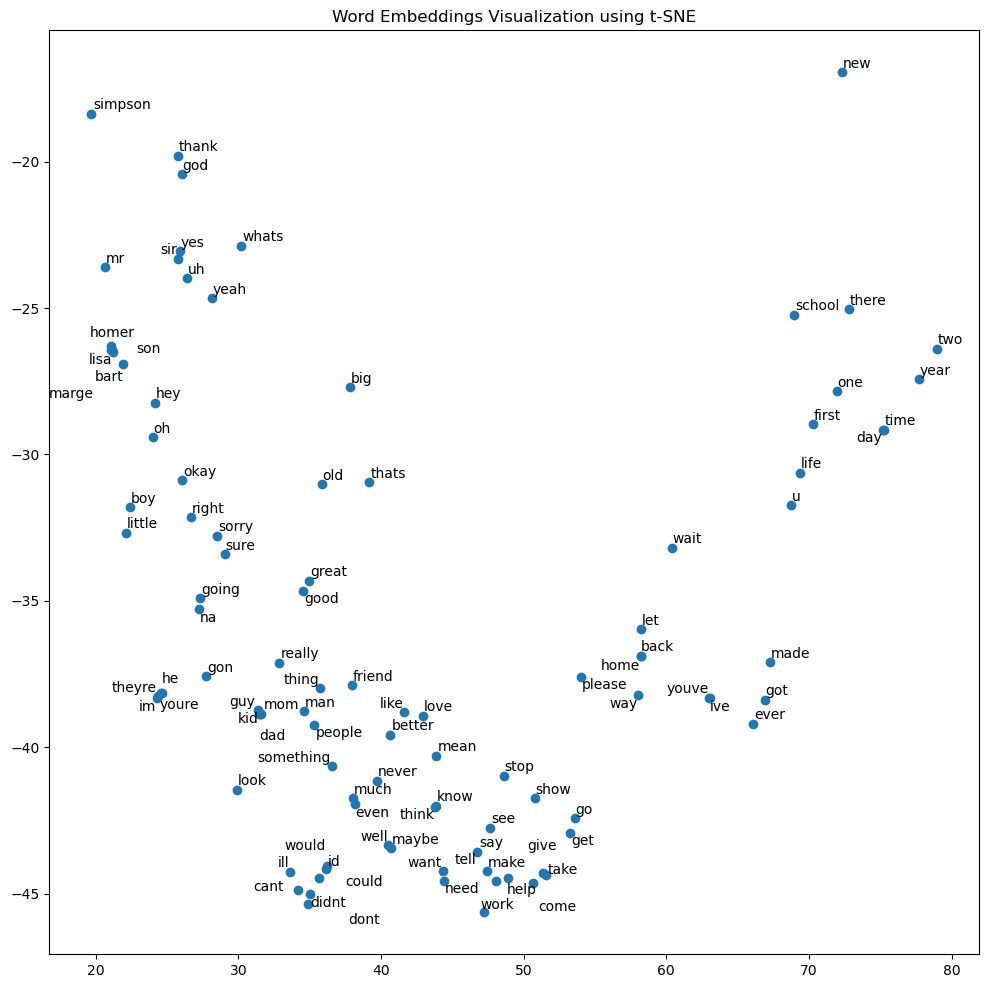

In [654]:
top = 100
top_words = model.wv.index_to_key[:top]
plt.figure(figsize=(12, 12))
plt.scatter(word_vectors_2d[:top, 0], word_vectors_2d[:top, 1])
texts = [plt.text(word_vectors_2d[i, 0], word_vectors_2d[i, 1], word, fontsize=10) for i, word in enumerate(top_words)]
adjust_text(texts)
plt.title("Word Embeddings Visualization using t-SNE")
plt.show()

Как видно некоторые слова сгруппировались, а именно:
- имена персонажей
- слова отрицания
- guy, mom, man, people, dad
- like, love
- глаголы: stop, see, say, take
- и др

## Найдем самые близкие слова для: 
- homer - marge + bart 
- bart - lisa + school 
- marge - homer + home

In [656]:
result = model.wv.most_similar(positive=['homer', 'bart'], negative=['marge'], topn=10)
result

[('lisa', 0.8622966408729553),
 ('grampa', 0.7786160707473755),
 ('j', 0.775653600692749),
 ('abe', 0.7721544504165649),
 ('bartholomew', 0.7618066072463989),
 ('mr', 0.7315225005149841),
 ('milhouse', 0.7294183969497681),
 ('showboating', 0.7292415499687195),
 ('abraham', 0.7281079292297363),
 ('eliza', 0.7256541848182678)]

Тут вроде очевидно, что результат Lisa, так как она дочь Marge

In [657]:
result = model.wv.most_similar(positive=['bart', 'school'], negative=['lisa'], topn=10)
result

[('class', 0.795728862285614),
 ('today', 0.7752822637557983),
 ('high', 0.7717272043228149),
 ('bus', 0.7681974172592163),
 ('town', 0.763358473777771),
 ('test', 0.7603199481964111),
 ('bar', 0.7526285648345947),
 ('trip', 0.7524722814559937),
 ('early', 0.7437509298324585),
 ('sunday', 0.7436243295669556)]

Тут сложно мне понять результат, так как не знаю контекста этого мультфильма

In [658]:
result = model.wv.most_similar(positive=['marge', 'home'], negative=['homer'], topn=10)
result

[('bed', 0.8597913384437561),
 ('along', 0.8186908960342407),
 ('sleep', 0.8167943358421326),
 ('together', 0.8160274028778076),
 ('back', 0.8127487301826477),
 ('ahead', 0.7902049422264099),
 ('rest', 0.7887786030769348),
 ('free', 0.7685938477516174),
 ('em', 0.7617482542991638),
 ('soon', 0.7579746246337891)]

Тут скорее всего результат bed (кровать), потому что Marge занимается домом, а Homer всегда спит или отдыхает

## Попробуем построить классификатор bart/lisa с использованием этих эмбеддингов

[Вот тут есть обсуждение как word2vec подружить с RNN](https://discuss.pytorch.org/t/word2vec-as-input-to-lstm/40356)  
Но можно сделать проще, где просто в датасете подготовить нужные эмбендинги

### Примечание
- будем использовать эти же эмбеддинги, но только для полного набора слов, чтобы сохранить последовательность всех слов и манеру построения предложений двух этих персонажей

In [1135]:
vector_size = 300
model_w2v = gensim.models.Word2Vec(vector_size=vector_size, min_count=1)
model_w2v.build_vocab(corpuses_ds)
model_w2v.train(corpuses_ds, total_examples=model_w2v.corpus_count, epochs=100)

(1103212, 1171100)

In [1332]:
embedding_matrix = model_w2v.wv.vectors
word2vec_weights = torch.FloatTensor(embedding_matrix)

In [1296]:
word2index = {word: index for index, word in enumerate(model_w2v.wv.index_to_key)}
word2index['padding_token'] = len(word2index)+1

In [1297]:
embedding_dim = vector_size
num_embeddings = len(word2index)

In [1329]:
embedding_matrix_ = torch.zeros(num_embeddings, embedding_dim)

In [1330]:
for word, index in word2index.items():
    if word != 'padding_token':
        embedding_matrix_[index] = torch.tensor(word2vec_weights[index])

C:\Users\a.makey\AppData\Local\Temp\ipykernel_17296\437333713.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding_matrix_[index] = torch.tensor(word2vec_weights[index])


In [1136]:
num_classes = 2
input_size = 40
# будем ограничивать предложение только 20 словами
data = corpuses_ds
label = characters_ds

In [1343]:
class SentDataset(Dataset):

    def __init__(self, sentences, w2v_model, characters_, num_classes, input_size, transform=None):
        self.sentences = sentences
        self.w2v_model = w2v_model
        self.characters_ = characters_
        self.num_classes = num_classes
        self.input_size = input_size
        self.transform = transform

    def __getitem__(self, i):
        
        indices = torch.tensor([self.w2v_model.wv.get_index(word) for word in self.sentences[i]])
        corpus_size = len(indices)
        padding_idx = self.w2v_model.wv.vectors.shape[0]
        x = torch.zeros(self.input_size).int() + padding_idx
        x[:corpus_size] = indices[:corpus_size]
        y = torch.tensor(self.characters_[i]).long()

#         embedding = torch.tensor(self.w2v_model.wv[self.sentences[i]])
#         embedding_size = embedding.size(-1)
#         corpus_size = embedding.size(-2)
#         if corpus_size > self.input_size:
#             corpus_size = self.input_size
#         x = torch.zeros(self.input_size, embedding_size)
#         x[:corpus_size, :] = embedding[:corpus_size, :]
        if self.transform:
            x = self.transform(x)
        
        return (x, y)

    def __len__(self):
        return len(self.sentences)

In [1344]:
transform = None

In [1345]:
dataset = SentDataset(data, model_w2v, label, num_classes, input_size, transform)

In [1346]:
dataset[0]

(tensor([   0,  363,    0,  762,   43,  393,   23,    0,   16,  975, 2048, 4088,
         4088, 4088, 4088, 4088, 4088, 4088, 4088, 4088, 4088, 4088, 4088, 4088,
         4088, 4088, 4088, 4088, 4088, 4088, 4088, 4088, 4088, 4088, 4088, 4088,
         4088, 4088, 4088, 4088], dtype=torch.int32),
 tensor(0))

In [1347]:
total_samples = len(dataset)
train_samples = int(0.7 * total_samples)
train_indices = list(range(train_samples))
test_indices = list(range(train_samples, total_samples))
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [1348]:
len(dataset)

979

In [1349]:
batch_size = 2048

In [1350]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),
#     num_workers=param.num_workers
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=torch.cuda.is_available(),
#     num_workers=param.num_workers
)

In [1351]:
class RNNModel(torch.nn.Module):
    def __init__(self, embedding_size, hidden_size, num_layers, num_classes, embedding_matrix):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.embedding = torch.nn.Embedding.from_pretrained(embedding_matrix)
        self.rnn = torch.nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.lin = torch.nn.Linear(hidden_size*2, hidden_size//2)
        self.relu = torch.nn.ReLU()
        self.out = torch.nn.Linear(hidden_size//2, num_classes)


    def forward(self, x):
        embedding.weight.requires_grad=False
        x = self.embedding(x)
        output, hidden = self.rnn(x)
        output = output[:, -1, :]
        output = self.lin(output)
        output = self.relu(output)
        output = self.out(output)
        return output

In [1353]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

embedding_size = embedding_matrix.shape[1]
hidden_size = 128
num_layers = 2
rnn_model = RNNModel(embedding_size, hidden_size, num_layers, num_classes, embedding_matrix_)
rnn_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.05)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = None

### Примечание
- к сожалению не смог подобрать нужную модель, даже не знаю в чем может быть проблема, так как перебрал разные варианты
- проблема в данных? или в модели? или в параметрах обучения?

In [1357]:
num_epochs = 10
for epoch in range(num_epochs):
    
    rnn_model.train(True)
    train_loss = 0.0
    for i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = rnn_model(X)
        loss = criterion(outputs, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    
    rnn_model.train(False)
    test_loss = 0.0
    test_accu = 0.0
    for i, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.to(device)
        outputs = rnn_model(X)
        loss = criterion(outputs, y)
        test_loss += loss.item()
        
        predictions = outputs.argmax(dim=1)
        accuracy = (predictions == y).float().mean()    
        test_accu += accuracy.item()
        
    test_loss /= len(test_dataloader)
    test_accu /= len(test_dataloader)

    if scheduler:
        scheduler.step()
        
    print(f'epoch {epoch}: train loss {train_loss}, test loss {test_loss}, test accu {test_accu}')

epoch 0: train loss 0.6896162033081055, test loss 0.6923906207084656, test accu 0.5272108912467957
epoch 1: train loss 0.6895740032196045, test loss 0.692177414894104, test accu 0.5272108912467957
epoch 2: train loss 0.6896235346794128, test loss 0.692101001739502, test accu 0.5272108912467957
epoch 3: train loss 0.6896811723709106, test loss 0.6921157836914062, test accu 0.5272108912467957
epoch 4: train loss 0.6896336674690247, test loss 0.692224383354187, test accu 0.5272108912467957
epoch 5: train loss 0.6895483732223511, test loss 0.6924251317977905, test accu 0.5272108912467957
epoch 6: train loss 0.6895024180412292, test loss 0.6926428079605103, test accu 0.5272108912467957
epoch 7: train loss 0.6895098686218262, test loss 0.6927555799484253, test accu 0.5272108912467957
epoch 8: train loss 0.6895167231559753, test loss 0.6926937103271484, test accu 0.5272108912467957
epoch 9: train loss 0.6894782781600952, test loss 0.6924959421157837, test accu 0.5272108912467957


In [1356]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.01
#     param_group['weight_decay'] = 0

In [1209]:
rnn_model.eval()

RNNModel(
  (rnn): LSTM(300, 128, num_layers=2, batch_first=True, bidirectional=True)
  (lin): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (out): Linear(in_features=64, out_features=2, bias=True)
)

In [1212]:
X, y = test_dataset[0]
print('модель', rnn_model(X.unsqueeze(0)).argmax(dim=1))
print('оригинал', y.item())

модель tensor([0])
оригинал 0


In [1213]:
X, y = test_dataset[1]
print('модель', rnn_model(X.unsqueeze(0)).argmax(dim=1))
print('оригинал', y.item())

модель tensor([0])
оригинал 0


## Итого
- попробовал много чего, но у меня ничего не получилось
- если есть тут решение, хотелось бы на него посмотреть и понять, где я тут делаю ошибку и на чем застрял